In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = 'C:\\Users\\Soonju\\Desktop\Aiffel\\Ex4_Stock\\MSFT.csv'
df = pd.read_csv(dataset_filepath) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-15,328.609985,335.190002,324.500000,334.649994,331.543365,35381100
1,2021-12-16,335.709991,336.760010,323.019989,324.899994,321.883911,35034800
2,2021-12-17,320.880005,324.920013,317.250000,323.799988,320.794128,47750300
3,2021-12-20,320.049988,322.799988,317.570007,319.910004,316.940247,28326500
4,2021-12-21,323.290009,327.730011,319.799988,327.290009,324.251709,24740600


# STEP 1 : 시계열 데이터 준비

In [2]:
# Date 인덱스로 빼고, Close 열만 뽑기
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))  # Series 확인
ts.head()


<class 'pandas.core.series.Series'>


Date
2021-12-15    334.649994
2021-12-16    324.899994
2021-12-17    323.799988
2021-12-20    319.910004
2021-12-21    327.290009
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행


(결측치처리, 로그변환)

In [3]:
# 결측치 처리
ts.isnull().sum()

# 있으면 .fillna(0)

0

In [4]:
# lms방법
ts = ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

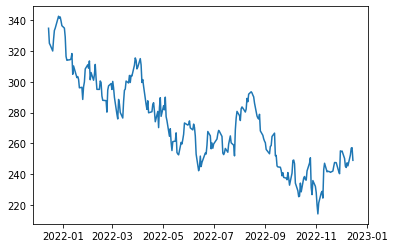

In [5]:
plt.plot(ts)

In [6]:
ts_log = np.log(ts)

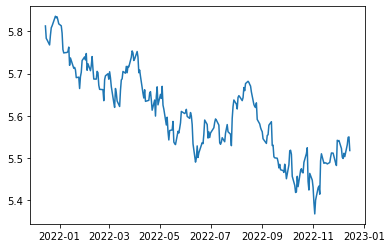

In [7]:
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [8]:
# 시계열을 하려면, 세가지 (이동평균, 이동표준편차, 자기공분산) 이 일정해야함
# 이것을 함께 보여주는 그래프를 그려보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

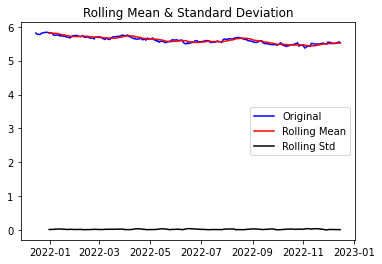

Results of Dickey-Fuller Test:
Test Statistic                  -2.216989
p-value                          0.200137
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


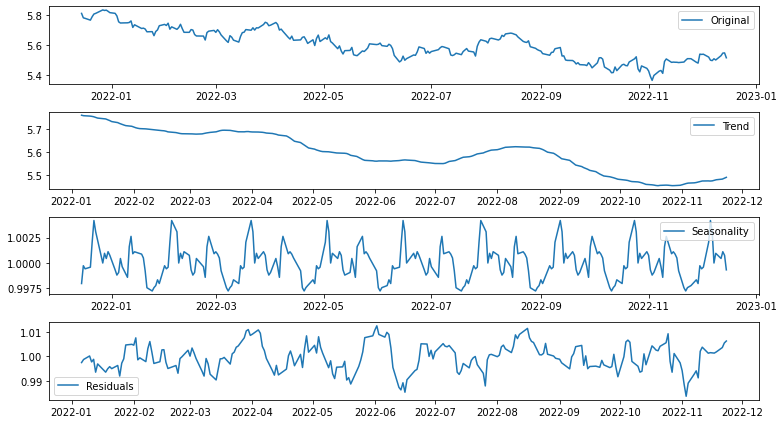

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)  # p-value :  0.59

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 ) 추출
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화) 추출
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성 빼주기


plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)  # p-value =  6.234854e-08

Results of Dickey-Fuller Test:
Test Statistic                -6.094582e+00
p-value                        1.017290e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

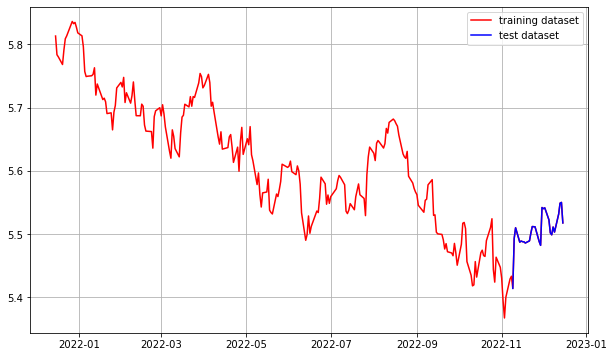

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


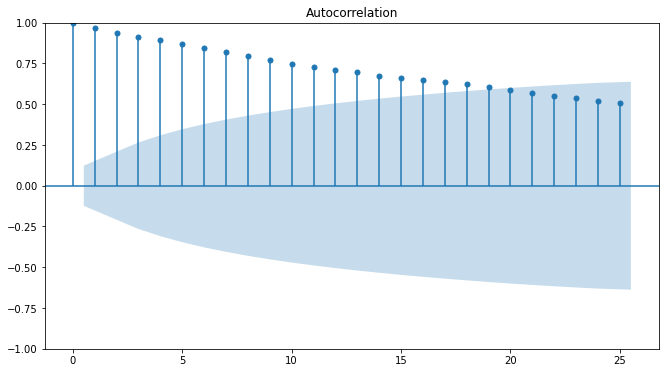

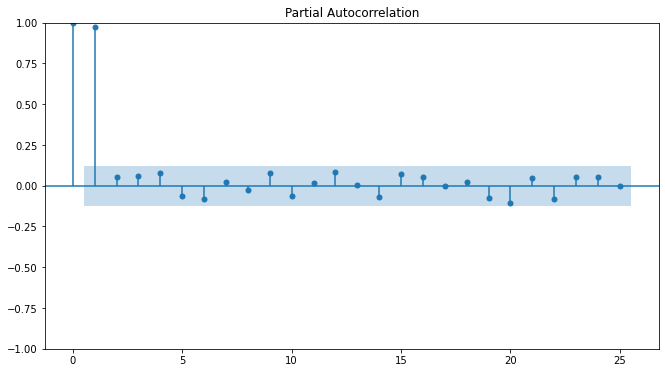

In [13]:
# statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용하여 parameter p,d,q 정하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   
# ACF : Autocorrelation (자기상관계수) 그래프 그리기 
# x:상관계수, y:시차수
# AR(p)에서는 점차적으로 감소하고, MA(q) 이후에 0이 되므로 q를 결정할 수 있음.

plot_pacf(ts_log)  
# PACF : Partial Autocorrelation (부분적 자기상관계수) 그래프 그리기
# AR(p)에서는 0이 되고, MA(q) 에서는 감소하므로, p를 결정할 수 있음.
plt.show()

https://www.youtube.com/watch?v=gqryqIlvEoM

Results of Dickey-Fuller Test:
Test Statistic                -1.063579e+01
p-value                        5.076687e-19
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


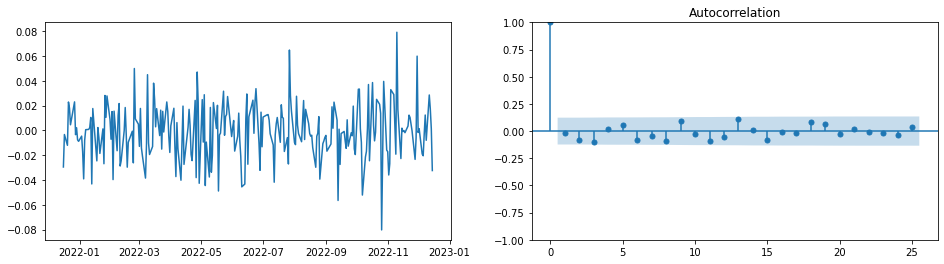

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff_1)
ax1.set_title=('Difference 1st')
plot_acf(diff_1, ax=ax2)

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -8.353688e+00
p-value                        2.947972e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


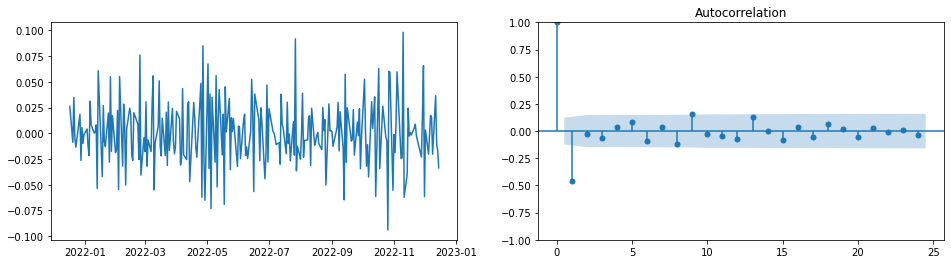

In [15]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff_2)
ax1.set_title=('Difference 2nd')
plot_acf(diff_2, ax=ax2)

augmented_dickey_fuller_test(diff_2)

C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


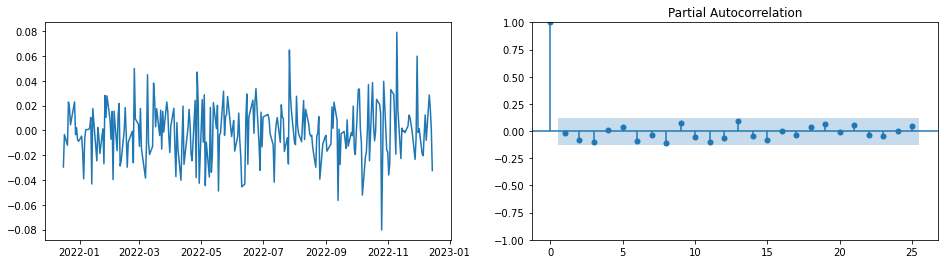

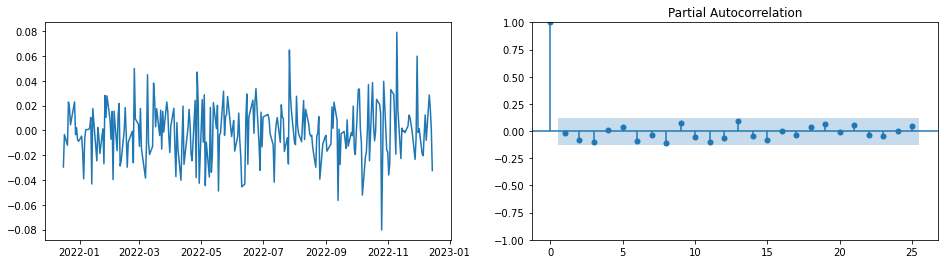

In [16]:
diff_1 = ts_log.diff(periods=1).iloc[1:]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff_1)
ax1.set_title=('Difference 1st')
plot_pacf(diff_1, ax=ax2)

C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


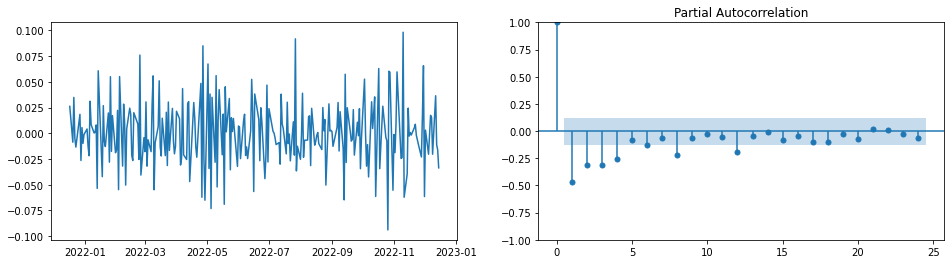

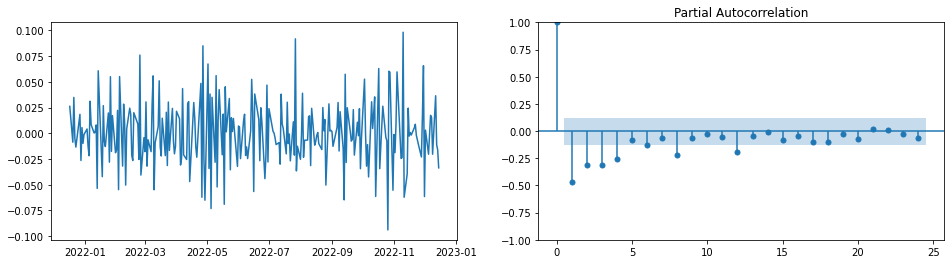

In [17]:
# (참고)
diff_2 = diff_1.diff(periods=1).iloc[1:]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff_2)
ax1.set_title=('Difference 2nd')
plot_pacf(diff_2, ax=ax2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

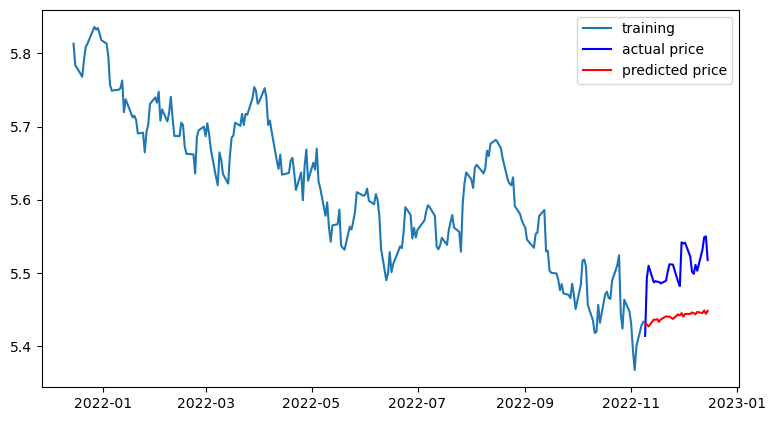

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# p = 2,3,6,9,13
# q = 2,3,6,9,13
# ARIMA model fit 하기 
model = ARIMA(train_data, order=(6,1,6))  # 6,1,6 이 그중 결과 제일 좋음
fitted_m1 = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

#2,1,2 =7.76% / 6,1,6 = 6.41% /

MSE:  282.0673895529051
MAE:  15.91271507123989
RMSE:  16.7948619986264
MAPE: 6.41%
